# SAT scores of NYC schools and Demographics#

The SAT, or Scholastic Aptitude Test, is an exam that U.S. high school students take before applying to college. Colleges take the test scores into account when deciding who to admit, so it's fairly important to perform well on it.

The test consists of three sections, each of which has 800 possible points. The combined score is out of 2,400 possible points (while this number has changed a few times, the data set for our project is based on 2,400 total points). Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality.

Investigating the correlations between SAT scores and demographics is an interesting angle to take. We could correlate SAT scores with factors like race, gender, income, and more.

By doing some research about the Newyork ity and its districts we can learn the following facts:

- Only high school students take the SAT, so we'll want to focus on high schools.
- New York City is made up of five boroughs, which are essentially distinct regions.
- New York City schools fall within several different school districts, each of which can contains dozens of schools.

## Data##
New York City makes its [data on high school SAT scores](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) available online, as well as the [demographics for each high school](https://data.cityofnewyork.us/Education/2014-2015-DOE-High-School-Directory/n3p6-zve2).

The same website has several related data sets covering demographic information and test scores. Here are the links to all of the data sets we'll be using:

- [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - The percentage of students who graduated, and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

All of these data sets are interrelated. We'll need to combine them into a single data set before we can find correlations. Each school in New York City has a unique code called a DBN, or district borough number. DBN can be used to combine data from different data sets.

## Read in the data
We will read data from different csv files and save them in a dictionary called data.

In [1]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]
#data is a dictionary with the key of the file name and value of the dataframe:
data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read in the surveys
Surveys are in txt files with different encodings. We are going to read them and save in data dictionary. There are about 2000 columns that we do not need most of them. 
First, we'll need to make the name of 'dbn' column uppercase and then filter the columns to remove the ones we don't need. The list of relevant columns will be saved in suervey_fields.

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

## Add some required columns
Before combining data, we need to add some columns to the dataframes. We need them all to have **DBN** column, which is a unique identifier for each school. When we explored all of the data sets, we noticed that class_size does not have a DBN column.
By exploring data we can tell that the DBN in the sat_results data is just a combination of the CSD and SCHOOL CODE columns in the class_size data. The main difference is that the DBN is padded so that the CSD portion of it always consists of two digits. That means we'll need to add a leading 0 to the CSD if the CSD is less than two digits long.

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

The other needed column is the column that totals up the **SAT scores** for the different sections of the exam. This will make it much easier to correlate scores with demographic factors because we'll be working with a single number, rather than three different ones.

Next, we are going to extract the **latitude** and **longitude** from "Location 1" column for each school and save them in different columns.

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets
For combining the dataframes in the data, DBN should be unique in all of them. we noticed that the values in the DBN column were unique in the sat_results data set, but Other data sets like class_size had duplicate DBN values, however.

We'll need to condense these data sets so that each value in the DBN column is unique. If not, we'll run into issues when it comes time to combine the data sets. To resolve this issue, we'll condense the following data sets:

- class_size 
- demographics
- graduation

**class_size**: For condensing the class_size we need to do the following:

- Because we're dealing with high school, we only want to pick rows where the value in the GRADE column is 09-12.
- Looking at the unique values for PROGRAM TYPE, we get GEN ED is the largest category, so let's only select rows where PROGRAM TYPE is GEN ED.
- After these two filterings, DBN is not still unique and it seems it is because of different courses for each row so we are going to group by DBN and make average on the other columns.

**demographics**: For condensing demographics we will select the rows where schoolyear is 20112012.

**graduation**
The Demographic and Cohort columns are what prevent DBN from being unique in the graduation data. A Cohort appears to refer to the year the data represents, and the Demographic appears to refer to a specific demographic group. In this case, we want to pick data from the most recent Cohort available, which is 2006. We also want data from the full cohort, so we'll only pick rows where Demographic is Total Cohort.

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric
It will be interesting to find out whether AP exam scores are correlated with SAT scores across high schools. To determine this, we'll need to convert the AP exam scores in the ap_2010 data set to numeric values first.

There are three columns we'll need to convert:

- AP Test Takers (note that there's a trailing space in the column name)
- Total Exams Taken
- Number of Exams with scores 3 4 or 5

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets
After cleaning data it is the time to merge all the data sets. Our strategy is summarized below:

-DBN is the column we use to merge based on.
- Since we are going to correlate the demographic factors with SAT score, we will want to preserve as many rows as possible from SAT score while minimizing null values.
- Some of the data sets have a lot of missing DBN values. This makes a left join more appropriate because we don't want to lose too many rows when we merge.
- Some data sets have DBN values that are almost identical to those in sat_results. Inner join is the proper option for these data sets

So we are going to merge the data sets with this plan:

- Both the **ap_2010** and the **graduation** data sets have many missing DBN values, so we'll use a **left** join 
- Because **class_size**, **demographics**, **survey**, and **hs_directory** contain information that's more valuable to our analysis and also have fewer missing DBN values, we'll use the **inner** join type.
- After merging we will fill all null values with the mean value of that column. If all values in a column is null, we will fill it with 0.

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

## Add a school district column for mapping

It is an interesting way to analyze the statistics based on a school district level. Adding a column to the data set that specifies the school district is helpful to accomplish this.

The school district is just the first two characters of the DBN. We will save it in **school_dist** column.

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Analysis by finding correlations
We are going to calculate all the correlations  with sat score and investigate those that show relationships with the sat score.

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


In general, r values above .25 or below -.25 are enough to qualify a correlation as interesting. These are the columns that show correlation with sat score:

- **total_enrolment** has a positive correlation with sat_score so smaller schools where students receive more attention do not have higher scores.
- Other columns like **total_students**, **N_s**, **N_p**, **N_t**, **AP Test Takers**, **Total Exams Taken**, and **NUMBER OF SECTIONS**, that are proxies for enrollment correlate with sat_score. The correlation confirms that larger schools do better on the SAT.
- **female_per** and **female_num** correlate positively with SAT score, whereas **male_per** and **male_num** correlate negatively. This could indicate that women do better than men.
- Teacher and student ratings of school safety (**saf_t_11**, and **saf_s_11**) correlate positively with sat_score.
- Student ratings of school academic standards (**aca_s_11**) correlate positively with sat_score, but this does not hold for ratings from teachers and parents (aca_p_11 and aca_t_11).
- There is significant racial inequality in SAT scores (**white_per, asian_per, black_per, hispanic_per**).
- The percentage of English language learners at the school (**ell_percent, frl_percent**) has a strong negative correlation with SAT scores.

We are going to draw some scatter plots to figure out if the correlation really exists.

## Correlation of total_enrolment and SAT Score
The r (= 0.367857) shows a positive correlation between the total number of enrolment and sat score. So let's make a scatter plot and investigate the relationship.

Text(0.5, 1.0, 'SAT score vs total enrollment')

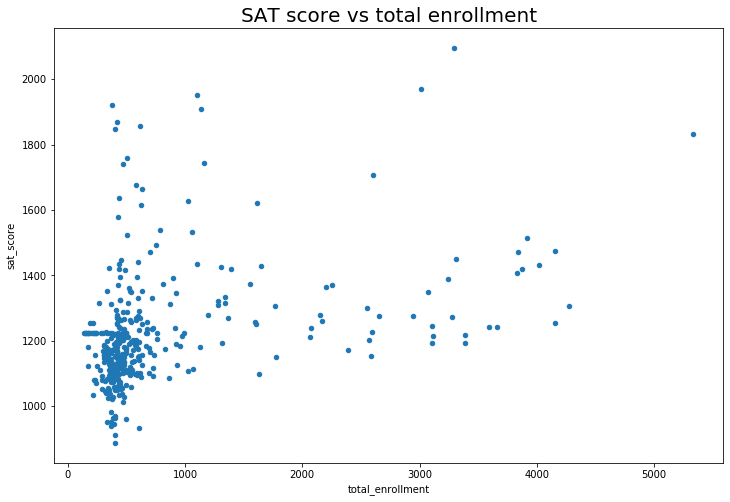

In [10]:
#Set up matplotlib to work in Jupyter notebook.
%matplotlib inline
import matplotlib.pyplot as plt
ax = combined.plot.scatter(x="total_enrollment", y="sat_score", figsize = (12, 8))
ax.set_title("SAT score vs total enrollment", fontdict={'fontsize':20})

Judging from the plot we just created, it doesn't appear that there's an extremely strong correlation between sat_score and total_enrollment. There's a large cluster of schools, and then a few others going off in three different directions.

However, there's an interesting cluster of points at the bottom left where total_enrollment and sat_score are both low. This cluster may be what's making the r-value so high. It's worth extracting the names of the schools in this cluster so we can research them further.

In [11]:
low_enrollment = combined[(combined['total_enrollment'] < 1000) & (combined['sat_score'] < 1000)]
print(low_enrollment['School Name'])

91       INTERNATIONAL COMMUNITY HIGH SCHOOL
125                                        0
126          BRONX INTERNATIONAL HIGH SCHOOL
139    KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
141    INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176                                        0
179            HIGH SCHOOL OF WORLD CULTURES
188       BROOKLYN INTERNATIONAL HIGH SCHOOL
225    INTERNATIONAL HIGH SCHOOL AT PROSPECT
237               IT TAKES A VILLAGE ACADEMY
253                MULTICULTURAL HIGH SCHOOL
286    PAN AMERICAN INTERNATIONAL HIGH SCHOO
Name: School Name, dtype: object


Our research about the above schools reveals that These schools have a high percentage of English learners. This indicates that it's actually ell_percent that correlates strongly with sat_score, rather than total_enrollment. To explore this relationship further, let's plot out ell_percent vs sat_score.

Text(0.5, 1.0, 'SAT score vs English Learners Percent')

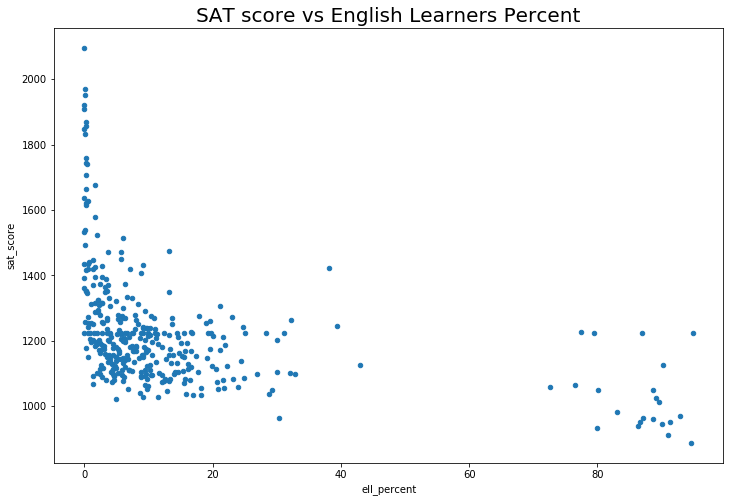

In [12]:
ax = combined.plot.scatter(x = 'ell_percent', y = 'sat_score', figsize = (12, 8))
ax.set_title("SAT score vs English Learners Percent", fontdict={'fontsize':20})

It looks like ell_percent correlates with sat_score more strongly because the scatterplot is more linear. However, there's still the cluster of schools that have very high ell_percent values and low sat_score values. This cluster represents the same group of international high schools we investigated earlier.
In order to explore this relationship, we'll want to map out ell_percent by school district. The map will show us which areas of the city have a lot of English language learners. To make it more clear we can aggregate by district, which will enable us to plot ell_percent district-by-district instead of school-by-school.

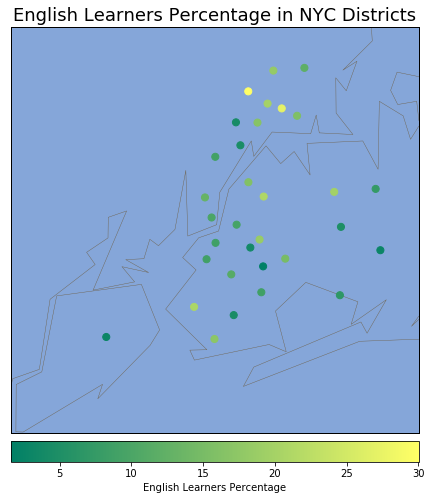

In [13]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy
districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace = True)

def draw_map(df, col_name, color_label, title):
    from mpl_toolkits.basemap import Basemap
    plt.figure(figsize=(8,8))
    m = Basemap(
        projection='merc', 
        llcrnrlat=40.496044, 
        urcrnrlat=40.915256, 
        llcrnrlon=-74.255735, 
        urcrnrlon=-73.700272,
        resolution='i'
    )

    m.drawmapboundary(fill_color='#85A6D9')
    m.drawcoastlines(color='#6D5F47', linewidth=.4)
    m.drawrivers(color='#6D5F47', linewidth=.4)

    longitudes = df['lon'].tolist()
    latitudes = df['lat'].tolist()
    m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=df[col_name], cmap="summer")
    m.colorbar(location='bottom', label=color_label)
    plt.title(title, fontdict={'fontsize':18})
    plt.show()
    
draw_map(districts, "ell_percent", "English Learners Percentage", "English Learners Percentage in NYC Districts")

The above map shows these districts have more English Learners Percentage:

- North of Manhattan
- Southwest of Bronx
- Northwest of Queens
- Southwest of Brooklyn

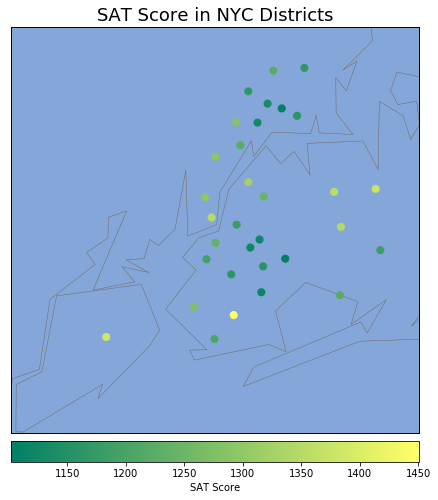

In [14]:
draw_map(districts, "sat_score", "SAT Score", "SAT Score in NYC Districts")

Comparing two plots above shows that most of the districts with high sat score have low English learners percentage and vice versa with two exceptions:

1. In the north and center of Brooklyn, there are some districts with a low number of English Learners percentage and low sat_score. 
2. There are a few districts in the north and northwest of Queens with a high number of English learners percentage and high sat score. 

## Plotting survey correlations

There are several fields in combined that originally came from a survey of parents, teachers, and students. Let's make a bar plot of the correlations between these fields and sat_score. These fields are in the survey_fields variable.

In [15]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")


In [16]:
print(survey_fields)

['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']


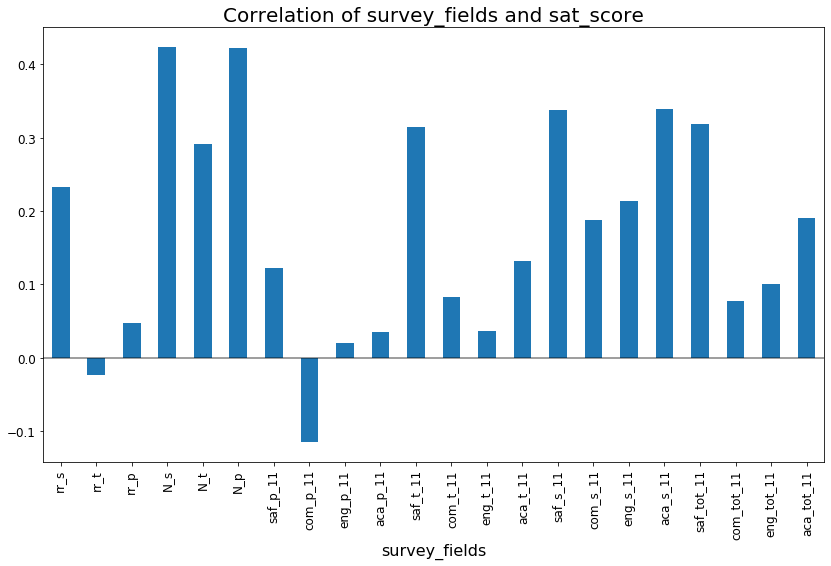

In [17]:
ax = correlations[survey_fields].plot.bar(rot = 90, figsize = (14, 8))
ax.set_title('Correlation of survey_fields and sat_score', fontdict={'fontsize':20})
ax.tick_params(labelsize = 'large')
ax.set_xlabel('survey_fields', fontdict={'fontsize':16})
ax.axhline(0, c='black', alpha=0.5)

The following fields seem correlated to sat_score:

- N_s        (Number of student respondents): This is the most correlated field
- N_p        (Number of parent respondents)
- aca_s_11   (Academic expectations score based on student responses)
- saf_s_11   (Safety and Respect score based on student responses)
- saf_tot_11 (Safety and Respect total score)
- saf_t_11   (Safety and Respect score based on teacher responses)
- N_t        (Number of teacher respondents)

To really assess whether or not a correlation exists, we need to look at the data using a scatterplot to see its "shape."

## Correlation of Saftey and respect scores with SAT Score ##
Among the correlated fields, there are saf_t_11 and saf_s_11, which measure how teachers and students perceive safety at school. We are going to dig into this relationship a bit more using a scatter plot and try to figure out which schools have low safety scores.

Text(0.5, 1.0, 'SAT score vs Safty score')

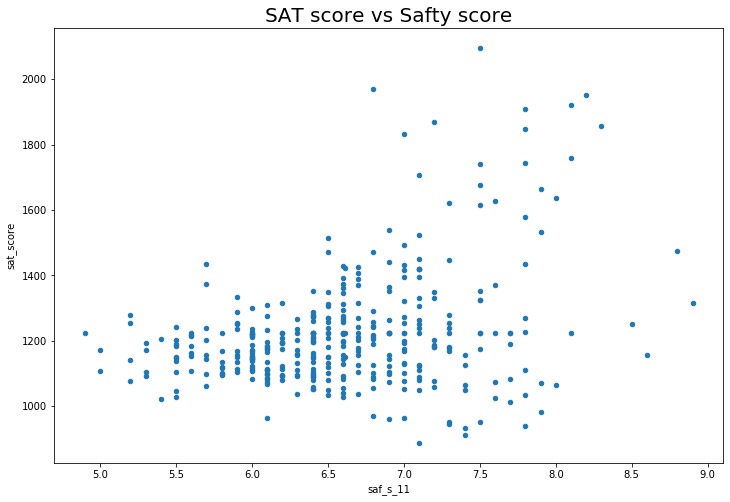

In [18]:
ax = combined.plot.scatter(x="saf_s_11", y="sat_score", figsize = (12, 8))
ax.set_title("SAT score vs Safty score", fontdict={'fontsize':20})

The above plots show that there are some schools with high safety and high sat score and there are some with lower safety and lower sat_score. There are a few schools with high safety and low sat scores. Most of the schools are under 6.8 of safety with a sat score of less than 1600.

Let's map out safety scores and see which districts have less safety. We should calculate the average of the safety score for each school district and then map them out.

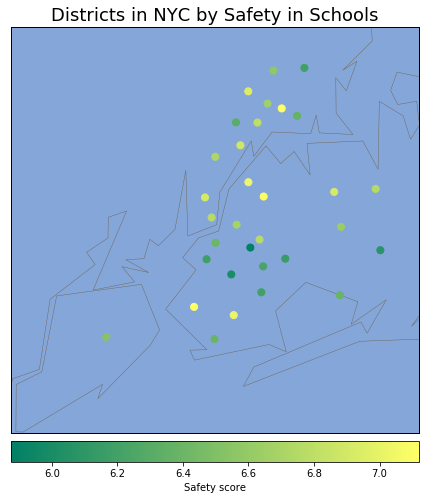

In [19]:
draw_map(districts, "saf_s_11", "Safety score", "Districts in NYC by Safety in Schools")

Manhattan, Queens, and south Brooklyn show higher safety according to the students' responses. The lowest safety scores are mostly given in the middle of Brooklyn districts.

## Correlation of Race and SAT Score##
There are a few columns that indicate the percentage of each race at a given school:

- white_per
- asian_per
- black_per
- hispanic_per

By plotting out the correlations between these columns and sat_score, we can determine whether there are any racial differences in SAT performance.

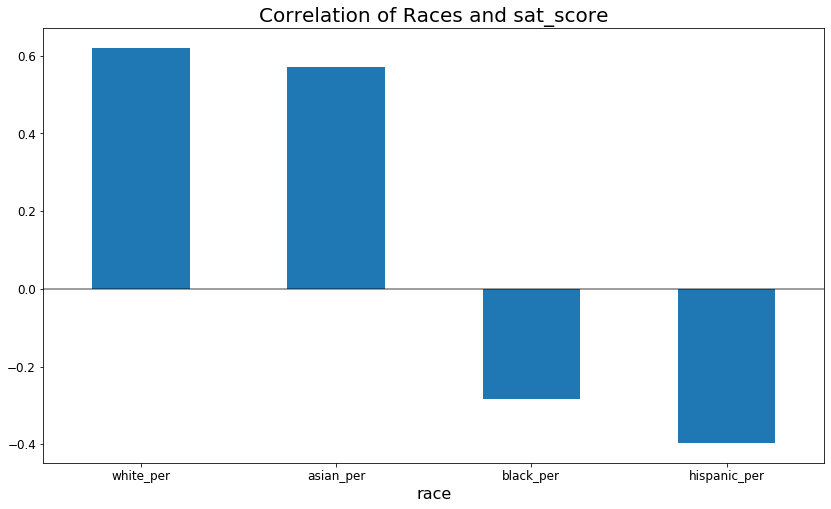

In [20]:
race_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
ax = correlations[race_cols].plot.bar(rot = 0, figsize = (14, 8))
ax.set_title('Correlation of Races and sat_score', fontdict={'fontsize':20})
ax.tick_params(labelsize = 'large')
ax.set_xlabel('race', fontdict={'fontsize':16})
ax.axhline(0, c='black', alpha=0.5)

The above bar plot shows that all races and the SAT score are correlated. All of them are above 0.25 or lower than -0.25. The higher percent of White and Asian students can cause higher sat score and a higher percent of Hispanic and Black students can cause lower sat scores. We are going to make the scatter plot to make sure about that.

Text(0.5, 1.0, 'SAT score Hispanic percent')

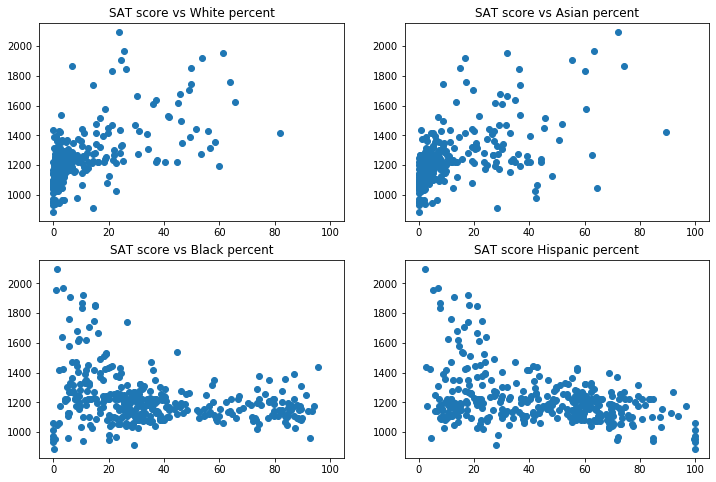

In [21]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.scatter(combined['white_per'], combined['sat_score'])
ax1.set_xlim(-5, 105)
ax1.set_title('SAT score vs White percent')
ax2.scatter(combined['asian_per'], combined['sat_score'])
ax2.set_xlim(-5, 105)
ax2.set_title('SAT score vs Asian percent')
ax3.scatter(combined['black_per'], combined['sat_score'])
ax3.set_xlim(-5, 105)
ax3.set_title('SAT score vs Black percent')
ax4.scatter(combined['hispanic_per'], combined['sat_score'])
ax4.set_xlim(-5, 105)
ax4.set_title('SAT score Hispanic percent')

Looking at the above plots, Hispanic percent shows a stronger relationship with the sat score. The plot shows that increasing the number of Hispanic students results in decreasing the SAT score. Let's research about the schools with a hispanic_per greater than 95% and find their names.

In [22]:
combined[combined['hispanic_per']>95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Most of these schools are in Manhattan and Bronx and have a high number of English learners.
Now it is good to research any schools with a hispanic_per of less than 10% and an average SAT score greater than 1800.

In [23]:
combined[(combined['hispanic_per']<10) & 
         (combined['sat_score'] > 1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

The above information shows that these schools are distributed in all boroughs. They also have no English learners and a low number of low-income students.

## Correlation of Gender and SAT score##
There are two columns that indicate the percentage of each gender at a school:

- male_per
- female_per

We can plot out the correlations between each percentage and sat_score.

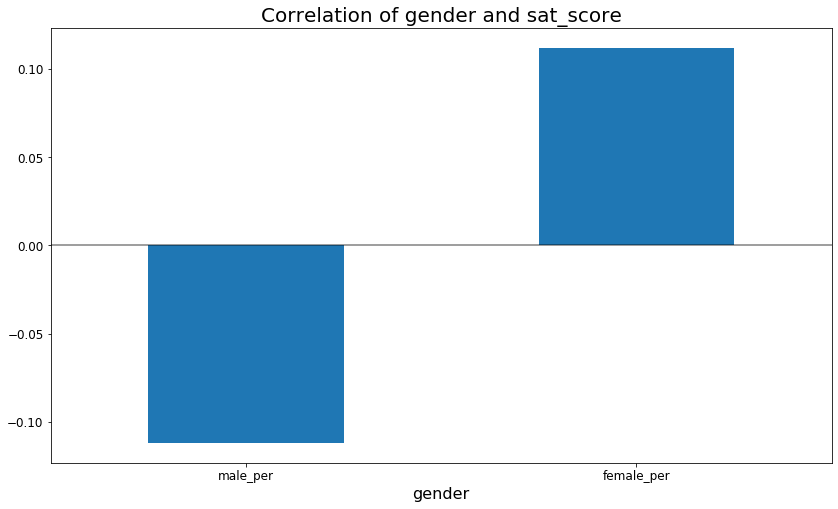

In [24]:
gender_cols = ['male_per', 'female_per']
ax = correlations[gender_cols].plot.bar(rot = 0, figsize = (14, 8))
ax.set_title('Correlation of gender and sat_score', fontdict={'fontsize':20})
ax.tick_params(labelsize = 'large')
ax.set_xlabel('gender', fontdict={'fontsize':16})
ax.axhline(0, c='black', alpha=0.5)

The above bar plot shows that a higher female percentage and lower male percentage may cause a higher sat score but because the correlation coefficient is not higher than 0.25 or lower than -0.25, there is no strong correlation between gender and sat score.
We are going to make a scatter plot to make sure about it.

Text(0.5, 1.0, 'SAT score vs Female Percent')

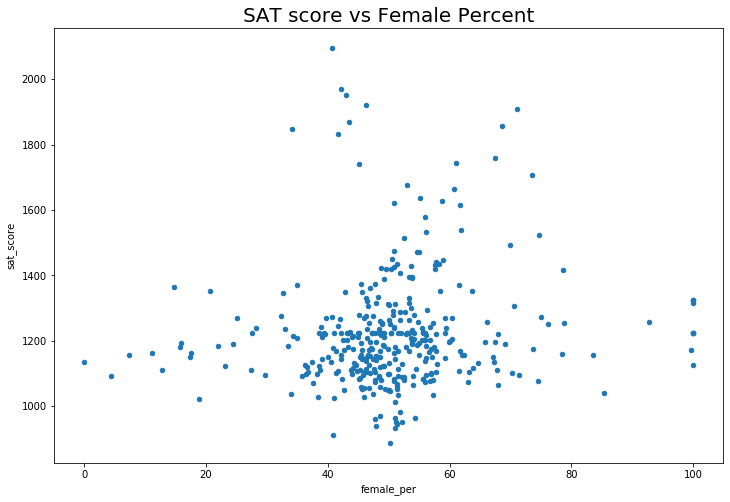

In [25]:
ax = combined.plot.scatter(x="female_per", y="sat_score", figsize = (12, 8))
ax.set_title("SAT score vs Female Percent", fontdict={'fontsize':20})

Schools with a sat score above 1700 have the female percentage between 30 and 80. It seems there is no meaningful relationship between gender and sat score.
We are going to research any schools with a female_per greater than 60% and an average SAT score greater than 1700.

In [26]:
combined[(combined['female_per']>60) & 
         (combined['sat_score'] > 1700)]['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Four out of these five schools are in Manhattan with a low number of low-income students and no English learners. The percentage of White and Asian students is higher than the other races in these five schools.

## Correlation of Advanced Placement (AP) and SAT score##
In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.

It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. Let's explore this relationship. Because total_enrollment is highly correlated with sat_score, we don't want to bias our results. Instead, we'll look at the percentage of students in each school who took at least one AP exam.

First, we need to calculate the percentage of students in each school that took the AP exam and assigns the result to the ap_per column. 

In [27]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

Text(0.5, 1.0, 'SAT score vs AP percentage')

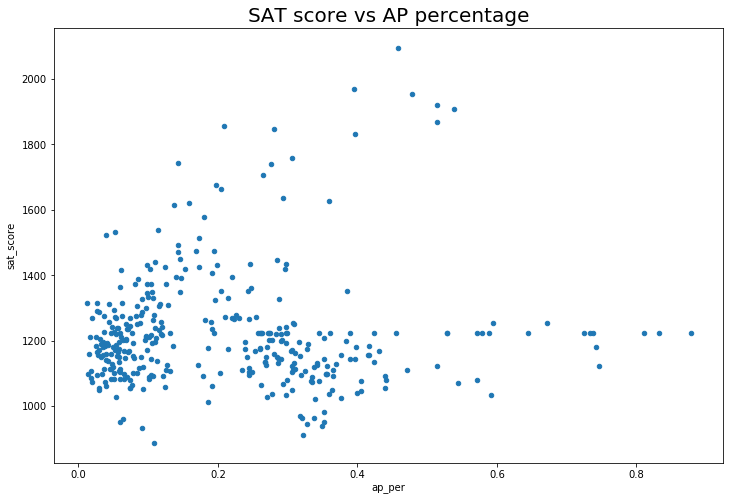

In [28]:
ax = combined.plot.scatter(x="ap_per", y="sat_score", figsize = (12, 8))
ax.set_title("SAT score vs AP percentage", fontdict={'fontsize':20})

Judging from the plot we just created, it seems there is a correlation between sat_score and ap_per but it is not a strong correlation. 

There's a large cluster of schools with low ap_per and low sat_score, and then a few others going off in two different directions. There are some schools with high sat scores that have high ap_per but the ap_per is less than 60%. The schools with ap_per bigger than 60% have low sat scores which make the correlation weak.
Let's look at the schools which have ap_per > 0.6.

In [29]:
combined[combined['ap_per']> 0.6][['SCHOOL NAME','AP Test Takers ','total_enrollment']]

,SCHOOL NAME,AP Test Takers,total_enrollment
6,47 THE AMERICAN SIGN LANGUAGE AND ENGLISH SECO...,129.028846,174
31,MANHATTAN ACADEMY FOR ARTS & LANGUAGE,129.028846,175
33,INTERNATIONAL HIGH SCHOOL AT UNION SQUARE,129.028846,176
50,HUMANITIES PREPARATORY ACADEMY,129.028846,192
83,HIGH SCHOOL FOR EXCELLENCE AND INNOVATION,129.028846,178
111,BRONX BRIDGES HIGH SCHOOL,129.028846,155
208,FRANCES PERKINS ACADEMY,129.028846,173
222,THE BROOKLYN ACADEMY OF GLOBAL FINANCE,129.028846,159
321,HILLSIDE ARTS & LETTERS ACADEMY,129.028846,200
335,CAMBRIA HEIGHTS ACADEMY,129.028846,147


The information above shows that all AP Test Takers value is the same and equal to the mean of this column so it reminds us about replacing null values with means. It seems these values are misleading us to analyze well about the correlation so let's look at the scatter again without these values.

Text(0.5, 1.0, 'SAT score vs AP percentage without null replaced values')

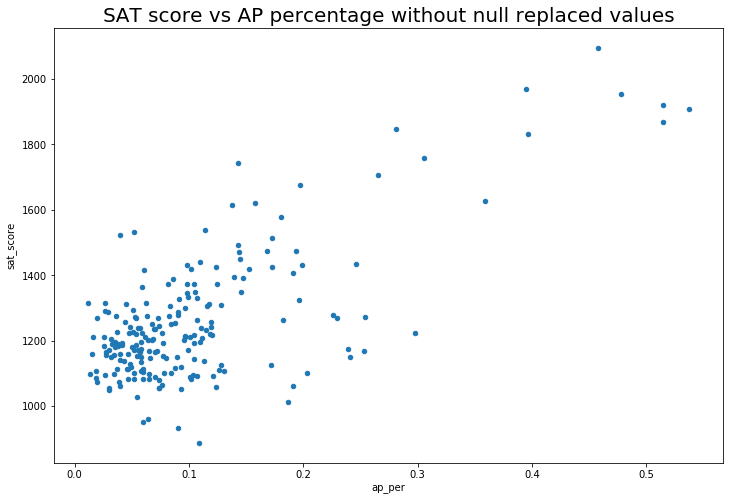

In [30]:
ax = combined[combined['AP Test Takers '] != 129.02884615384616].plot.scatter(x="ap_per", y="sat_score", figsize = (12, 8))
ax.set_title("SAT score vs AP percentage without null replaced values", fontdict={'fontsize':20})

The above scatter plot shows correlation between ap_per and sat_score more strongly. 

## Correlation between Class size and SAT Scores##

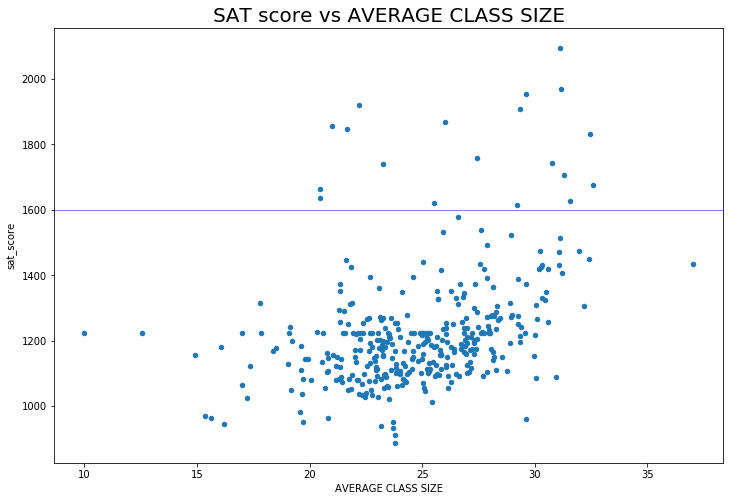

In [31]:
ax = combined.plot.scatter(x="AVERAGE CLASS SIZE", y="sat_score", figsize = (12, 8))
ax.set_title("SAT score vs AVERAGE CLASS SIZE", fontdict={'fontsize':20})
ax.axhline(y=1600,xmin=0,xmax=3,c="blue",linewidth=0.5,zorder=0)

In [32]:
print(correlations['AVERAGE CLASS SIZE'])

0.3810143308095523


By looking at the plot, we figure out that class size for schools with the sat score of under 1600, is more correlated with the sat score.

## Differences between Parent, teacher and student respones##
At this point, we are going to investigate the differences between parent, teacher, and student responses to surveys and their correlation with the sat score. The columns that we are going to explore are:

- N_s (Number of student respondents): correlation is 0.423
- N_p (Number of parent respondents): correlation is 0.422
- N_t (Number of teacher respondents): correlation is 0.291

Let's look at the scatters and compare them.

Text(0.5, 1.0, 'SAT score vs Number of teacher responses')

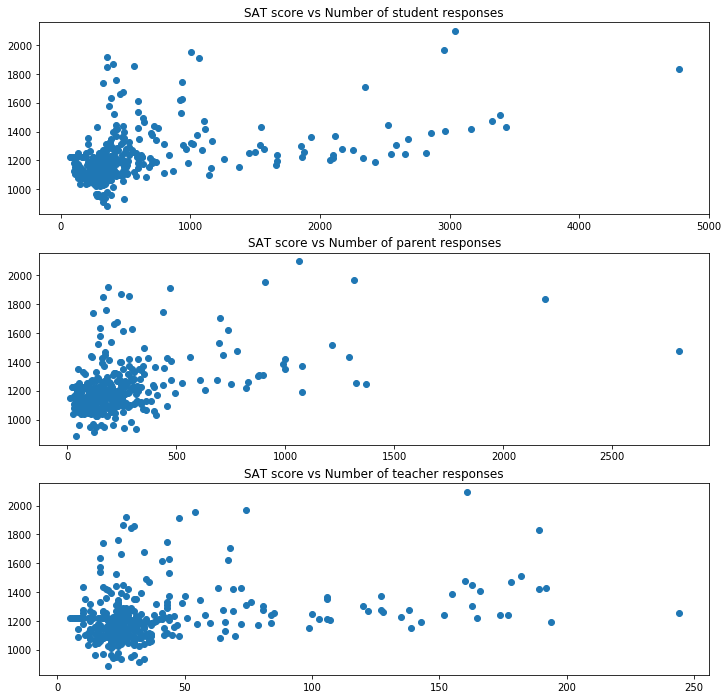

In [33]:
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)

ax1.scatter(combined['N_s'], combined['sat_score'])
ax1.set_title('SAT score vs Number of student responses')
ax2.scatter(combined['N_p'], combined['sat_score'])
ax2.set_title('SAT score vs Number of parent responses')
ax3.scatter(combined['N_t'], combined['sat_score'])
ax3.set_title('SAT score vs Number of teacher responses')

The above plots confirms the correlations specially for the schools with the SAT score of lower than 1600.

## Best schools in each Neighborhood##

It can be helpful to figure out which neighborhoods have the best schools.
If we combine this information with a dataset containing property values, we could find the least expensive neighborhoods that have good schools.

First, we need to find out the neighborhood of each school and write it in a separate column. So Let's look at the Location1 column and try to extract zip code and save it in the separate column.

In [34]:
print(combined['Location 1'][0])

220 Henry Street
New York, NY 10002
(40.71376394700047, -73.98526003999967)


In [35]:
def find_zipcode(loc):
    coords = re.findall("\(.+, .+\)", loc)
    zip_code = re.findall("NY\s[0-9]{5}", loc)
    return zip_code[0]
combined["zip_code"] = combined["Location 1"].apply(find_zipcode)
combined["zip_code"] = combined["zip_code"].str.replace("NY ", "")

Using this [reference](https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm) It can be a good idea to create a dictionary to map NYC neighborhoods and zip codes. Then we can write a function to find the neighborhood of a zip code. Using that function we can convert the zip_code column to a new column, called, neighborhood.

In [36]:
nb_zip_map = {'Central Bronx':[10453, 10457, 10460],
'Bronx Park and Fordham':[10458, 10467, 10468],
'High Bridge and Morrisania':[10451, 10452, 10456],
'Hunts Point and Mott Haven':[10454, 10455, 10459, 10474],
'Kingsbridge and Riverdale':[10463, 10471],
'Northeast Bronx':[10466, 10469, 10470, 10475],
'Southeast Bronx':[10461, 10462,10464, 10465, 10472, 10473],
'Central Brooklyn':[11212, 11213, 11216, 11233, 11238],
'Southwest Brooklyn':[11209, 11214, 11228],
'Borough Park':[11204, 11218, 11219, 11230],
'Canarsie and Flatlands':[11234, 11236, 11239],
'Southern Brooklyn':[11223, 11224, 11229, 11235],
'Northwest Brooklyn':[11201, 11205, 11215, 11217, 11231],
'Flatbush':[11203, 11210, 11225, 11226],
'East New York and New Lots':[11207, 11208],
'Greenpoint':[11211, 11222],
'Sunset Park':[11220, 11232],
'Bushwick and Williamsburg':[11206, 11221, 11237],
'Central Harlem':[10026, 10027, 10030, 10037, 10039],
'Chelsea and Clinton':[10001, 10011, 10018, 10019, 10020, 10036],
'East Harlem':[10029, 10035],
'Gramercy Park and Murray Hill':[10010, 10016, 10017, 10022],
'Greenwich Village and Soho':[10012, 10013, 10014],
'Lower Manhattan':[10004, 10005, 10006, 10007, 10038, 10280],
'Lower East Side':[10002, 10003, 10009],
'Upper East Side':[10021, 10028, 10044, 10065, 10075, 10128],
'Upper West Side':[10023, 10024, 10025],
'Inwood and Washington Heights':[10031, 10032, 10033, 10034, 10040],
'Northeast Queens':[11361, 11362, 11363, 11364],
'North Queens':[11354, 11355, 11356, 11357, 11358, 11359, 11360],
'Central Queens':[11365, 11366, 11367],
'Jamaica':[11412, 11423, 11432, 11433, 11434, 11435, 11436],
'Northwest Queens':[11101, 11102, 11103, 11104, 11105, 11106],
'West Central Queens':[11374, 11375, 11379, 11385],
'Rockaways':[11691, 11692, 11693, 11694, 11695, 11697],
'Southeast Queens':[11004, 11005, 11411, 11413, 11422, 11426, 11427, 11428, 11429],
'Southwest Queens':[11414, 11415, 11416, 11417, 11418, 11419, 11420, 11421],
'West Queens':[11368, 11369, 11370, 11372, 11373, 11377, 11378],
'Port Richmond':[10302, 10303, 10310],
'South Shore':[10306, 10307, 10308, 10309, 10312],
'Stapleton and St. George':[10301, 10304, 10305],
'Mid-Island':[10314]}

In [37]:
def find_neighborhood(zip):
    zip = int(zip)
    for key in nb_zip_map:
        value = nb_zip_map[key]
        for item in value:
            if item == zip:
                return key
#print(find_neighborhood('10002')           )
combined["neighborhood"] = combined["zip_code"].apply(find_neighborhood)

In [38]:
neighborhoods = combined.groupby("neighborhood").agg(numpy.mean)
neighborhoods.reset_index(inplace=True)
#neighborhoods.sort_values(by = 'sat_score', ascending = False)[['neighborhood', 'sat_score']]

A bar plot can show the sat score of all neighborhoods.

Text(0.5, 1.0, 'SAT score vs neighborhood')

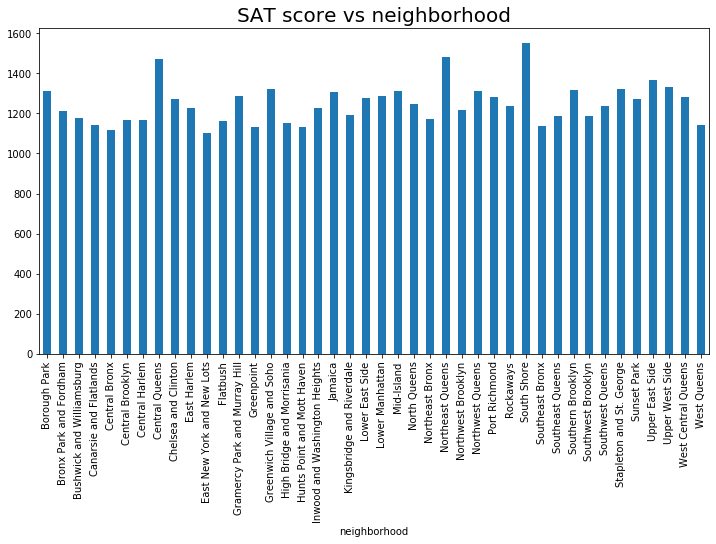

In [39]:
ax = neighborhoods.plot.bar(x = 'neighborhood',y = 'sat_score', legend = False ,figsize = (12, 6))
ax.set_title("SAT score vs neighborhood", fontdict={'fontsize':20})

The above plot demonstrates South Shore, Northeast, and Central Queens are the first three neighborhoods that have the highest sat scores.
It can be a good idea to look at the neighborhoods based on the number of English learners too and see what are the best neighborhoods according to the number of English learners.

In [40]:
def ell_categorize(val):
    if pd.isnull(val):
        return np.nan
    elif val<10:
        return 'Less than 10'
    elif val<=20:
        return '10-20'
    elif val<=30:
        return '20-30'
    else:
        return 'More than 30'
    
neighborhoods['ell_cat'] = neighborhoods['ell_percent'].apply(ell_categorize)
neighborhoods_ell = neighborhoods.groupby(["neighborhood", 'ell_cat']).agg(numpy.mean)
neighborhoods_ell.reset_index(inplace=True)
neighborhoods_ell.sort_values(by = ['ell_cat','sat_score'], ascending = False)[['neighborhood','ell_cat', 'sat_score']]

,neighborhood,ell_cat,sat_score
23,North Queens,More than 30,1244.250000
41,West Queens,More than 30,1142.000000
30,South Shore,Less than 10,1549.333333
25,Northeast Queens,Less than 10,1481.500000
7,Central Queens,Less than 10,1470.600000
39,Upper West Side,Less than 10,1331.631642
14,Greenwich Village and Soho,Less than 10,1321.000000
36,Stapleton and St. George,Less than 10,1320.666667
22,Mid-Island,Less than 10,1312.000000
18,Jamaica,Less than 10,1308.359701


Based on the above table, we can determine for each English Learner category the neighborhoods with the highest score are:

- **Less than 10** percent of English Learners: **South Shore** (State Island)
- **10 to 20** percent of English Learners: **Upper East Side** (Manhattan)
- **20 to 30** percent of English Learners: **Gramercy Park and Murray Hill** (Manhattan)
- **More than 30** percent of English Learners: **North Queens**

## Conclusion:
The aim of this project was investigating the correlations between SAT scores and demographics and the following results have been achieved:

1. **English Learners Percentage**: The percent of English learners correlates negatively with the sat score.  These districts have more English Learners Percentage:

    - North Manhattan
    - Southwest Bronx
    - Northwest Queens
    - Southwest Brooklyn
    
    The first three areas have the lowest sat score as well. The highest sat scores are in the following areas:
 
     - South Manhattan
     - East Queens
     - Southcentral Brooklyn
     - Staten Island
     
2. **Safty**: According to the investigation there is no strong correlation between Safty and sat score. These are the areas with higher safety according to the students' responses.:

    - Manhattan
    - Queens
    - South Brooklyn 
    
    The lowest safety scores are mostly given in the middle of Brooklyn districts.
 
3. **Race**: The r values of correlation show that students' race correlates with the sat score but the plots do not show it strongly. The only plot that shows the relationship stronger is Hispanic percent. More investigation showed that schools with a higher percentage of Hispanic students are schools with higher English learners as well.

4. **Gender**: There is no strong correlation between gender and sat score. The schools with high female percent and high sat scores are those that have no English learners.

5. **Advanced Placement Percentage**: Advanced Placement percent and SAT scores are correlated positively and strongly.

6. **Class size**: The class size of schools with a sat score of under 1600, is correlated strongly with the sat score.

7. **Number of Parent, teacher, and student responses**: They are correlated with sat score especially for the sat scores under 1600.

8. **Neighborhoods**: Looking at the neighborhoods we understood South Shore, Northeast, and Central Queens have the highest sat scores. By categorized according to the percentage of English learners the neighborhoods with the highest sat score are summarized below:

    - **Less than 10** percent of English Learners: South Shore (State Island)
    - **10 to 20** percent of English Learners: Upper East Side (Manhattan)
    - **20 to 30** percent of English Learners: Gramercy Park and Murray Hill (Manhattan) 
    - **More than 30** percent of English Learners: North Queens 
        